<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 변이형 오토인코더 (Variational Auto-Encoder) 학습하기

원본 코드 주소: https://colab.research.google.com/github/pytorchbearer/torchbearer/blob/master/docs/_static/notebooks/vae.ipynb#scrollTo=4Pc86tbWmw53


Torchbearer: PyTorch 모델을 피팅해주는 라이브러리. 현재는 Pytorch Lightning으로 옮겨졌습니다.

## Torchbearer 설치하기

먼저, torchbearer을 설치하겠습니다. 

In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

     |████████████████████████████████| 138 kB 22.5 MB/s 
0.5.3


## 모델 정의하기

먼저, PyTorch로 구현된 VAE 모델을 구현하겠습니다.  
변이형 오토인코더 중에서, Fully-connected layer (FC)로 구현된 버전을 구현해보겠습니다.   
FC의 입력 사이즈가 784인 이유는, 학습 데이터 MNIST의 해상도가 28 * 28 = 784이기 때문입니다. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)  # Encoder
        self.fc21 = nn.Linear(400, 20)  # Encoder - μ
        self.fc22 = nn.Linear(400, 20)  # Encoder - σ
        self.fc3 = nn.Linear(20, 400)   # Decoder
        self.fc4 = nn.Linear(400, 784)  # Decoder

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    ## Reparametrization Trick
    def reparameterize(self, mu, logvar): 
        if self.training:
            std = torch.exp(0.5*logvar) # torch.exp: exponentional
            eps = torch.randn_like(std) # torch.randn_like: std와 똑같은 사이즈로 정규분포 랜덤숫자 
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = self.fc4(h3)
        return torch.sigmoid(h4).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

torchbearers를 사용하여 약간의 수정을 해보겠습니다.
기존의 VAE를 overriding하여 torchbearerVAE를 구현해보겠습니다.  

여기서 우리는 torchbearer의 state_key 메소드를 사용해보겠습니다. (https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.state.state_key)  
 `MU` and `LOGVAR` 라는 이름으로 state_key를 저장하겠습니다. 

In [ ]:
import torchbearer

# Define state keys for storing things in torchbearers state
MU, LOGVAR = torchbearer.state_key('mu'), torchbearer.state_key('logvar')


class TorchbearerVAE(VAE):
    def forward(self, x, state):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        state[MU], state[LOGVAR] = mu, logvar
        return self.decode(z)

torchbearer VAE의 경우 평균과 로그 분산을 출력하는 대신 상태에 저장한다는 점을 제외하면 이러한 모델 간에는 거의 차이가 없습니다. 

이를 통해 손실뿐만 아니라 콜백 내에서 액세스할 수 있습니다.

## 손실함수 정의하기

이제 우리는 이모델의 손실함수에 대해 관찰해보겠습니다.  
먼저 standard VAE loss function를 구현해보겠습니다.

손실함수는 Reconstruction Loss와 KL-Divergence로 구성되어 있습니다.  

In [ ]:
def binary_cross_entropy(y_pred, y_true):
    BCE = F.binary_cross_entropy(y_pred.view(-1, 784), y_true.view(-1, 784), reduction='sum')
    return BCE
  
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # pow: power, exp: exponential
    return KLD

def loss_function(y_pred, y_true):
    recon_x, mu, logvar = y_pred
    x = y_true

    BCE = bce_loss(recon_x, x)

    KLD = kld_Loss(mu, logvar)

    return BCE + KLD

Torchbearer에는 이 손실을 정의하는 방법에 대한 몇 가지 옵션이 있습니다. 

Torchbearer 손실 함수는 (y_pred, y_true) 또는 (상태)의 함수일 수 있으므로 실제로 표준 손실 함수(상태 가져오기)를 사용하고 상태에서 평균 및 로그 분산을 가져올 수 있습니다.  
 
대신 기본 재구성 손실과 함께 KL 손실을 추가하는 "add_to_loss" 콜백 데코레이터를 보여줍니다.

In [ ]:
main_loss = binary_cross_entropy

@torchbearer.callbacks.add_to_loss
def add_kld_loss_callback(state):
    KLD = kld(state[MU], state[LOGVAR])
    return KLD

## 데이터

지금 데이터를 정의하겠습니다. 

대상(일반적으로 클래스 레이블)을 입력 이미지로 바꿀 수 있도록 PyTorch MNIST 데이터 세트를 래핑하는 간단한 데이터 세트 클래스를 만듭니다. 

여기에서 DatasetValidationSplitter를 사용하여 유효성 검사 세트를 얻습니다.

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

class AutoEncoderMNIST(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        character, label = self.mnist_dataset.__getitem__(index)
        return character, character

    def __len__(self):
        return len(self.mnist_dataset)


BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor()])

# Define standard classification mnist dataset with random validation set

dataset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
splitter = DatasetValidationSplitter(len(dataset), 0.1)
basetrainset = splitter.get_train_dataset(dataset)
basevalset = splitter.get_val_dataset(dataset)
basetestset = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=transform)

# Wrap base classification mnist dataset to return the image as the target

trainset = AutoEncoderMNIST(basetrainset)

valset = AutoEncoderMNIST(basevalset)

testset = AutoEncoderMNIST(basetestset)

traingen = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

valgen = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testgen = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 모델 시각화하기.

오토 인코딩 문제의 경우 재구성을 시각화하는 것이 종종 유용합니다. [`MakeGrid` 콜백]을 사용하여 torchbearer에서 이 작업을 수행할 수 있습니다.  


(https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.MakeGrid), from the [`imaging` sub-package](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#module-torchbearer.callbacks.imaging)

In [ ]:
from torchbearer.callbacks import imaging

targets = imaging.MakeGrid(torchbearer.TARGET, num_images=64, nrow=8)
targets = targets.on_test().to_pyplot().to_file('targets.png')

predictions = imaging.MakeGrid(torchbearer.PREDICTION, num_images=64, nrow=8)
predictions = predictions.on_test().to_pyplot().to_file('predictions.png')

위의 코드에서 두 개의 콜백을 만듭니다. 하나는 대상 이미지의 그리드를 만들고 다른 하나는 예측 그리드를 만듭니다. 이들은 파일에 저장되고 pyplot으로 플롯됩니다.

## 모델 학습하기

이제 모델을 학습시키겠습니다. 

Torchbearer 모델을 훈련하기 위해 먼저 'Trial'을 만든 다음 'run'을 호출합니다.

 그 과정에서 표시할 메트릭을 추가하고 시각화 콜백을 추가합니다. 
 
 **참고**: 여기서 'verbose=1'을 설정하면 진행률 표시줄이 각 에포크(각 배치가 아니라 많은 출력을 생성함)에 대해서만 틱해야 함을 의미합니다.

In [ ]:
import torch.optim as optim
from torchbearer import Trial

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TorchbearerVAE()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = binary_cross_entropy

trial = Trial(model, optimizer, main_loss, metrics=['acc', 'loss'],
                          callbacks=[add_kld_loss_callback, predictions, targets]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
_ = trial.run(epochs=10, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

We now evaluate on the test data, and see how well our model performed

0/1(e):   0%|          | 0/79 [00:00<?, ?it/s]

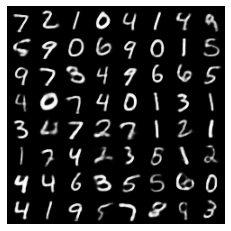

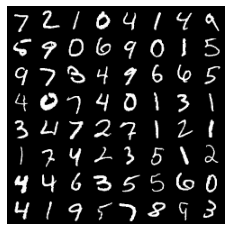

{'test_binary_acc': 0.9710549712181091, 'test_loss': 12382.603515625}

In [ ]:
trial.evaluate(data_key=torchbearer.TEST_DATA)